<a href="https://colab.research.google.com/github/afloresblas/BigDataProject/blob/main/Modin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# print('NOTE: Intentionally crashing session to use the newly installed library.\n')

# !pip uninstall -y pyarrow
# !pip install ray[debug]==0.7.5
# !pip install bs4

# # A hack to force the runtime to restart, needed to include the above dependencies.
# import os
# #os._exit(0)
# !pip install -U ipykernel
# !pip install modin[all]

In [2]:
import os
os.environ["MODIN_ENGINE"] = "ray"
import modin.pandas as pd
import numpy as np #Manejo de matrices y vectores
import scipy as sp #libreria para data science
#import pandas as pd #Manejo de iformacióón
import matplotlib.pyplot as plt #Visualización
import seaborn as sns #Visualización
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

**Carga de datos**

In [3]:
%time
df_application = pd.read_csv('/content/application_record.csv', encoding = 'utf-8')
df_record = pd.read_csv('/content/credit_record.csv', encoding = 'utf-8')   

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()



In [4]:
%time
df_application.head()

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.9 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
%time
df_record.head()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.5 µs


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**Pre-Procesamiento (limpieza)**

In [6]:
# Análisis de valores duplicados
## Id's únicos dentro del dataframe df_application
%time
print("Cantidad de registros dentro de df_application:",df_application.shape[0])
print("Cantidad de id's únicos dentro de df_application",df_application['ID'].nunique())
## NO coincide la cantidad de registros únicos con la cantidad de registros dentro
## del dataframe

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs
Cantidad de registros dentro de df_application: 438557
Cantidad de id's únicos dentro de df_application 438510


In [7]:
## Los valores duplicados dentro del dataset serán eliminados
df_application = df_application.drop_duplicates('ID', keep='last') 

In [8]:
## Id's únicos dentro del dataframe df_record
%time
print("Cantidad de registros dentro de df_record:",df_record.shape[0])
print("Cantidad de id's únicos dentro de df_record",df_record['ID'].nunique())
# NO coincide la cantidad de registros únicos con la cantidad de registros dentro
# porque son datos mensuales

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Cantidad de registros dentro de df_record: 1048575
Cantidad de id's únicos dentro de df_record 45985


In [9]:
## Número de id's que las dos tables comparten
%time
print(len(set(df_application["ID"]).intersection(set(df_record["ID"]))))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.4 µs
36457


In [10]:
# Análisis de valores nulos df_application
%time
print("-----------Análisis de valores nulos df_application-------------------")
print(df_application.isnull().sum())

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
-----------Análisis de valores nulos df_application-------------------
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64


In [11]:
# El campo OCCUPATION_TYPE tiene gran cantidad de valores nulos
# no se tomará en cuenta este campo por dicha razón
df_application.drop('OCCUPATION_TYPE', axis=1, inplace=True) 

In [12]:
# Análisis de valores nulos df_record
%time
print("-----------Análisis de valores nulos df_record-------------------")
print(df_record.isnull().sum())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
-----------Análisis de valores nulos df_record-------------------
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


In [13]:
# Análisis de columnas que tengan valores categóricos
df_application_cat = pd.DataFrame(df_application.dtypes == 'object').reset_index()
df_application_str = df_application_cat[df_application_cat[0]==True]['index']
df_application_str


1            CODE_GENDER
2           FLAG_OWN_CAR
3        FLAG_OWN_REALTY
6       NAME_INCOME_TYPE
7    NAME_EDUCATION_TYPE
8     NAME_FAMILY_STATUS
9      NAME_HOUSING_TYPE
Name: index, dtype: object

In [14]:
df_application_num = pd.DataFrame(df_application.dtypes != 'object').reset_index().\
rename(columns = {0:'yes/no'})
df_application_num = df_application_num[df_application_num['yes/no'] == True]['index']

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for x in df_application:
    if df_application[x].dtypes=='object':
        df_application[x] = le.fit_transform(df_application[x])

In [16]:
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,2.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,2.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,2.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0


In [17]:
df_application_num

0                   ID
4         CNT_CHILDREN
5     AMT_INCOME_TOTAL
10          DAYS_BIRTH
11       DAYS_EMPLOYED
12          FLAG_MOBIL
13     FLAG_WORK_PHONE
14          FLAG_PHONE
15          FLAG_EMAIL
16     CNT_FAM_MEMBERS
Name: index, dtype: object

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


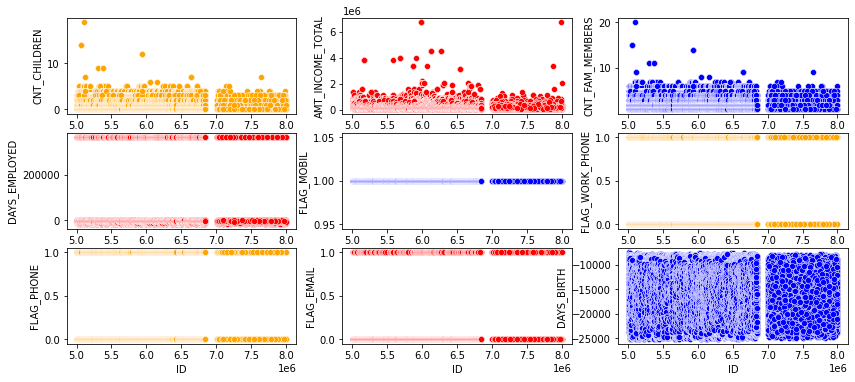

In [18]:
## Se halla que existen outliers en las columnas CNT_CHILDREN, AMT_INCOME_TOTAL y CNT_FAM_MEMBERS
%time
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df_application, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df_application, ax=ax[0][1], color='red')
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df_application, ax=ax[0][2], color='blue')
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df_application, ax=ax[1][0], color='red')
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=df_application, ax=ax[1][1], color='blue')
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=df_application, ax=ax[1][2], color='orange')
sns.scatterplot(x='ID', y='FLAG_PHONE', data=df_application, ax=ax[2][0], color='orange')
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=df_application, ax=ax[2][1], color='red')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df_application, ax=ax[2][2], color= 'blue')

In [19]:
#Depuración de outliers para el campo 'CNT_FAM_MEMBERS'
limite_superior = df_application['CNT_FAM_MEMBERS'].quantile(0.999)
limite_inferior = df_application['CNT_FAM_MEMBERS'].quantile(0.001)
df_application = df_application[(df_application['CNT_FAM_MEMBERS']<limite_superior) & (df_application['CNT_FAM_MEMBERS']>limite_inferior)]

(apply_func pid=15213) 


In [20]:
#Depuración de outliers para el campo 'AMT_INCOME_TOTAL'
limite_superior = df_application['AMT_INCOME_TOTAL'].quantile(0.999)
limite_inferior = df_application['AMT_INCOME_TOTAL'].quantile(0.001)
df_application = df_application[(df_application['AMT_INCOME_TOTAL']<limite_superior) & (df_application['AMT_INCOME_TOTAL']>limite_inferior)]

In [21]:
#Depuración de outliers para el campo 'CNT_CHILDREN'
limite_superior = df_application['CNT_CHILDREN'].quantile(0.999)
limite_inferior = df_application['CNT_CHILDREN'].quantile(0.001)
df_application = df_application[(df_application['CNT_CHILDREN']<limite_superior) & (df_application['CNT_CHILDREN']>limite_inferior)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


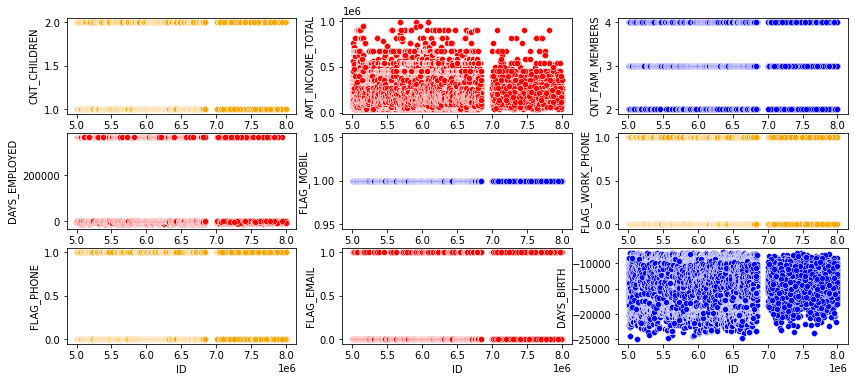

In [22]:
## Verificación de eliminación de outliers 'CNT_CHILDREN, AMT_INCOME_TOTAL y CNT_FAM_MEMBERS
%time
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df_application, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df_application, ax=ax[0][1], color='red')
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df_application, ax=ax[0][2], color='blue')
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df_application, ax=ax[1][0], color='red')
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=df_application, ax=ax[1][1], color='blue')
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=df_application, ax=ax[1][2], color='orange')
sns.scatterplot(x='ID', y='FLAG_PHONE', data=df_application, ax=ax[2][0], color='orange')
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=df_application, ax=ax[2][1], color='red')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df_application, ax=ax[2][2], color= 'blue')

In [23]:
## Dado que las dos tablas se deberán unir y el campo status del 
## df_record es lo que se debe predecir, se debe codificar
df_record['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
df_record['STATUS'] = df_record['STATUS'].astype('int')
df_record['STATUS'] = df_record['STATUS'].apply(lambda x:1 if x >= 2 else 0)


In [24]:
## Se observa que los datos nos stán balanceados
df_record['STATUS'].value_counts(normalize=True)

To request implementation, send an email to feature_requests@modin.org.


0    0.99704
1    0.00296
Name: STATUS, dtype: float64

In [25]:
# Unificación de las dos tablas
df_record = df_record.groupby('ID').agg(max).reset_index()
%time
#union = pd.merge(df_application, df_record, on="ID")
union = df_application.join(df_record.set_index('ID'), on='ID', how='inner')
union.drop(['MONTHS_BALANCE'], axis=1, inplace=True)
union.info()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs
<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 10725 entries, 24 to 434805
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  -------------------  --------------  -----  
 0   ID                   10725 non-null  int64
 1   CODE_GENDER          10725 non-null  int64
 2   FLAG_OWN_CAR         10725 non-null  int64
 3   FLAG_OWN_REALTY      10725 non-null  int64
 4   CNT_CHILDREN         10725 non-null  int64
 5   AMT_INCOME_TOTAL     10725 non-null  float64
 6   NAME_INCOME_TYPE     10725 non-null  int64
 7   NAME_EDUCATION_TYPE  10725 non-null  int64
 8   NAME_FAMILY_STATUS   10725 non-null  int64
 9   NAME_HOUSING_TYPE    10725 non-null  int64
 10  DAYS_BIRTH           10725 non-null  int64
 11  DAYS_EMPLOYED        10725 non-null  int64
 12  FLAG_MOBIL           10725 non-null  int64
 13  FLAG_WORK_PHONE      10725 non-null  int64
 14  FLAG_PHONE           10725 non-null  int6

In [26]:
union.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
24,5008834,0,0,1,1,112500.0,4,4,3,1,-10968,-1620,1,0,0,0,2.0,0
25,5008835,0,0,1,1,112500.0,4,4,3,1,-10968,-1620,1,0,0,0,2.0,0
29,5008838,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
30,5008839,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
31,5008840,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0


In [27]:
# Eliminación de columnas que no se usarán para el análisis
union.drop(columns=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], inplace=True)

Algunos análisis de la data

CPU times: user 0 ns, sys: 8 µs, total: 8 µs
Wall time: 26.7 µs
El 54.8% no tiene un vehículo


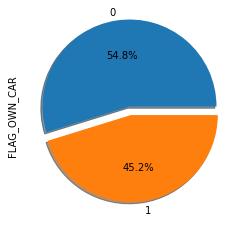

In [28]:
%time
print("El 54.8% no tiene un vehículo")
union['FLAG_OWN_CAR'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Del total el 61.3% son mujeres


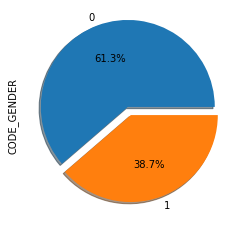

In [29]:
%time
print("Del total el 61.3% son mujeres")
union['CODE_GENDER'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

In [30]:
%time
print("La mayoría tiene 1 hijo")
union['CNT_CHILDREN'].value_counts()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
La mayoría tiene 1 hijo


1    7472
2    3253
Name: CNT_CHILDREN, dtype: int64

In [31]:
%time
print("La mayoría de usuarios tiene tres familiares")
union['CNT_FAM_MEMBERS'].value_counts()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
La mayoría de usuarios tiene tres familiares


3.0    6415
4.0    3077
2.0    1233
Name: CNT_FAM_MEMBERS, dtype: int64

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


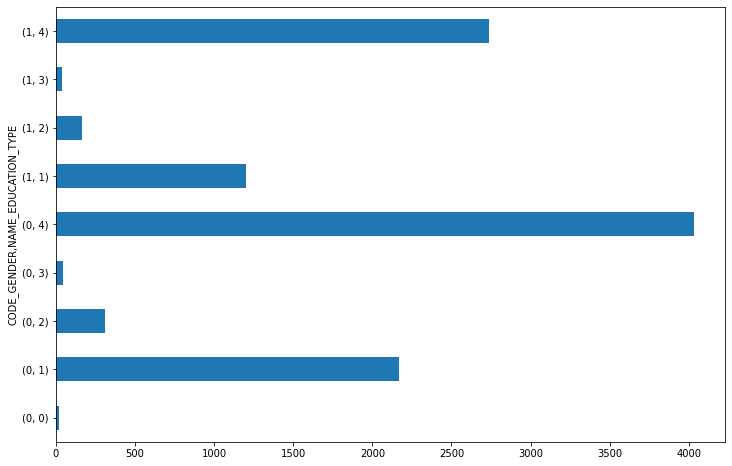

In [32]:
%time
union.groupby(['CODE_GENDER', 'NAME_EDUCATION_TYPE']).size().plot(kind='barh', figsize = (12, 8))

In [33]:
## Cast de datos y eliminación de filas que contengan valores nulos
%time
df_union = union.dropna()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Las familias que tienen tres hijos son las que mayor ingreso perciben


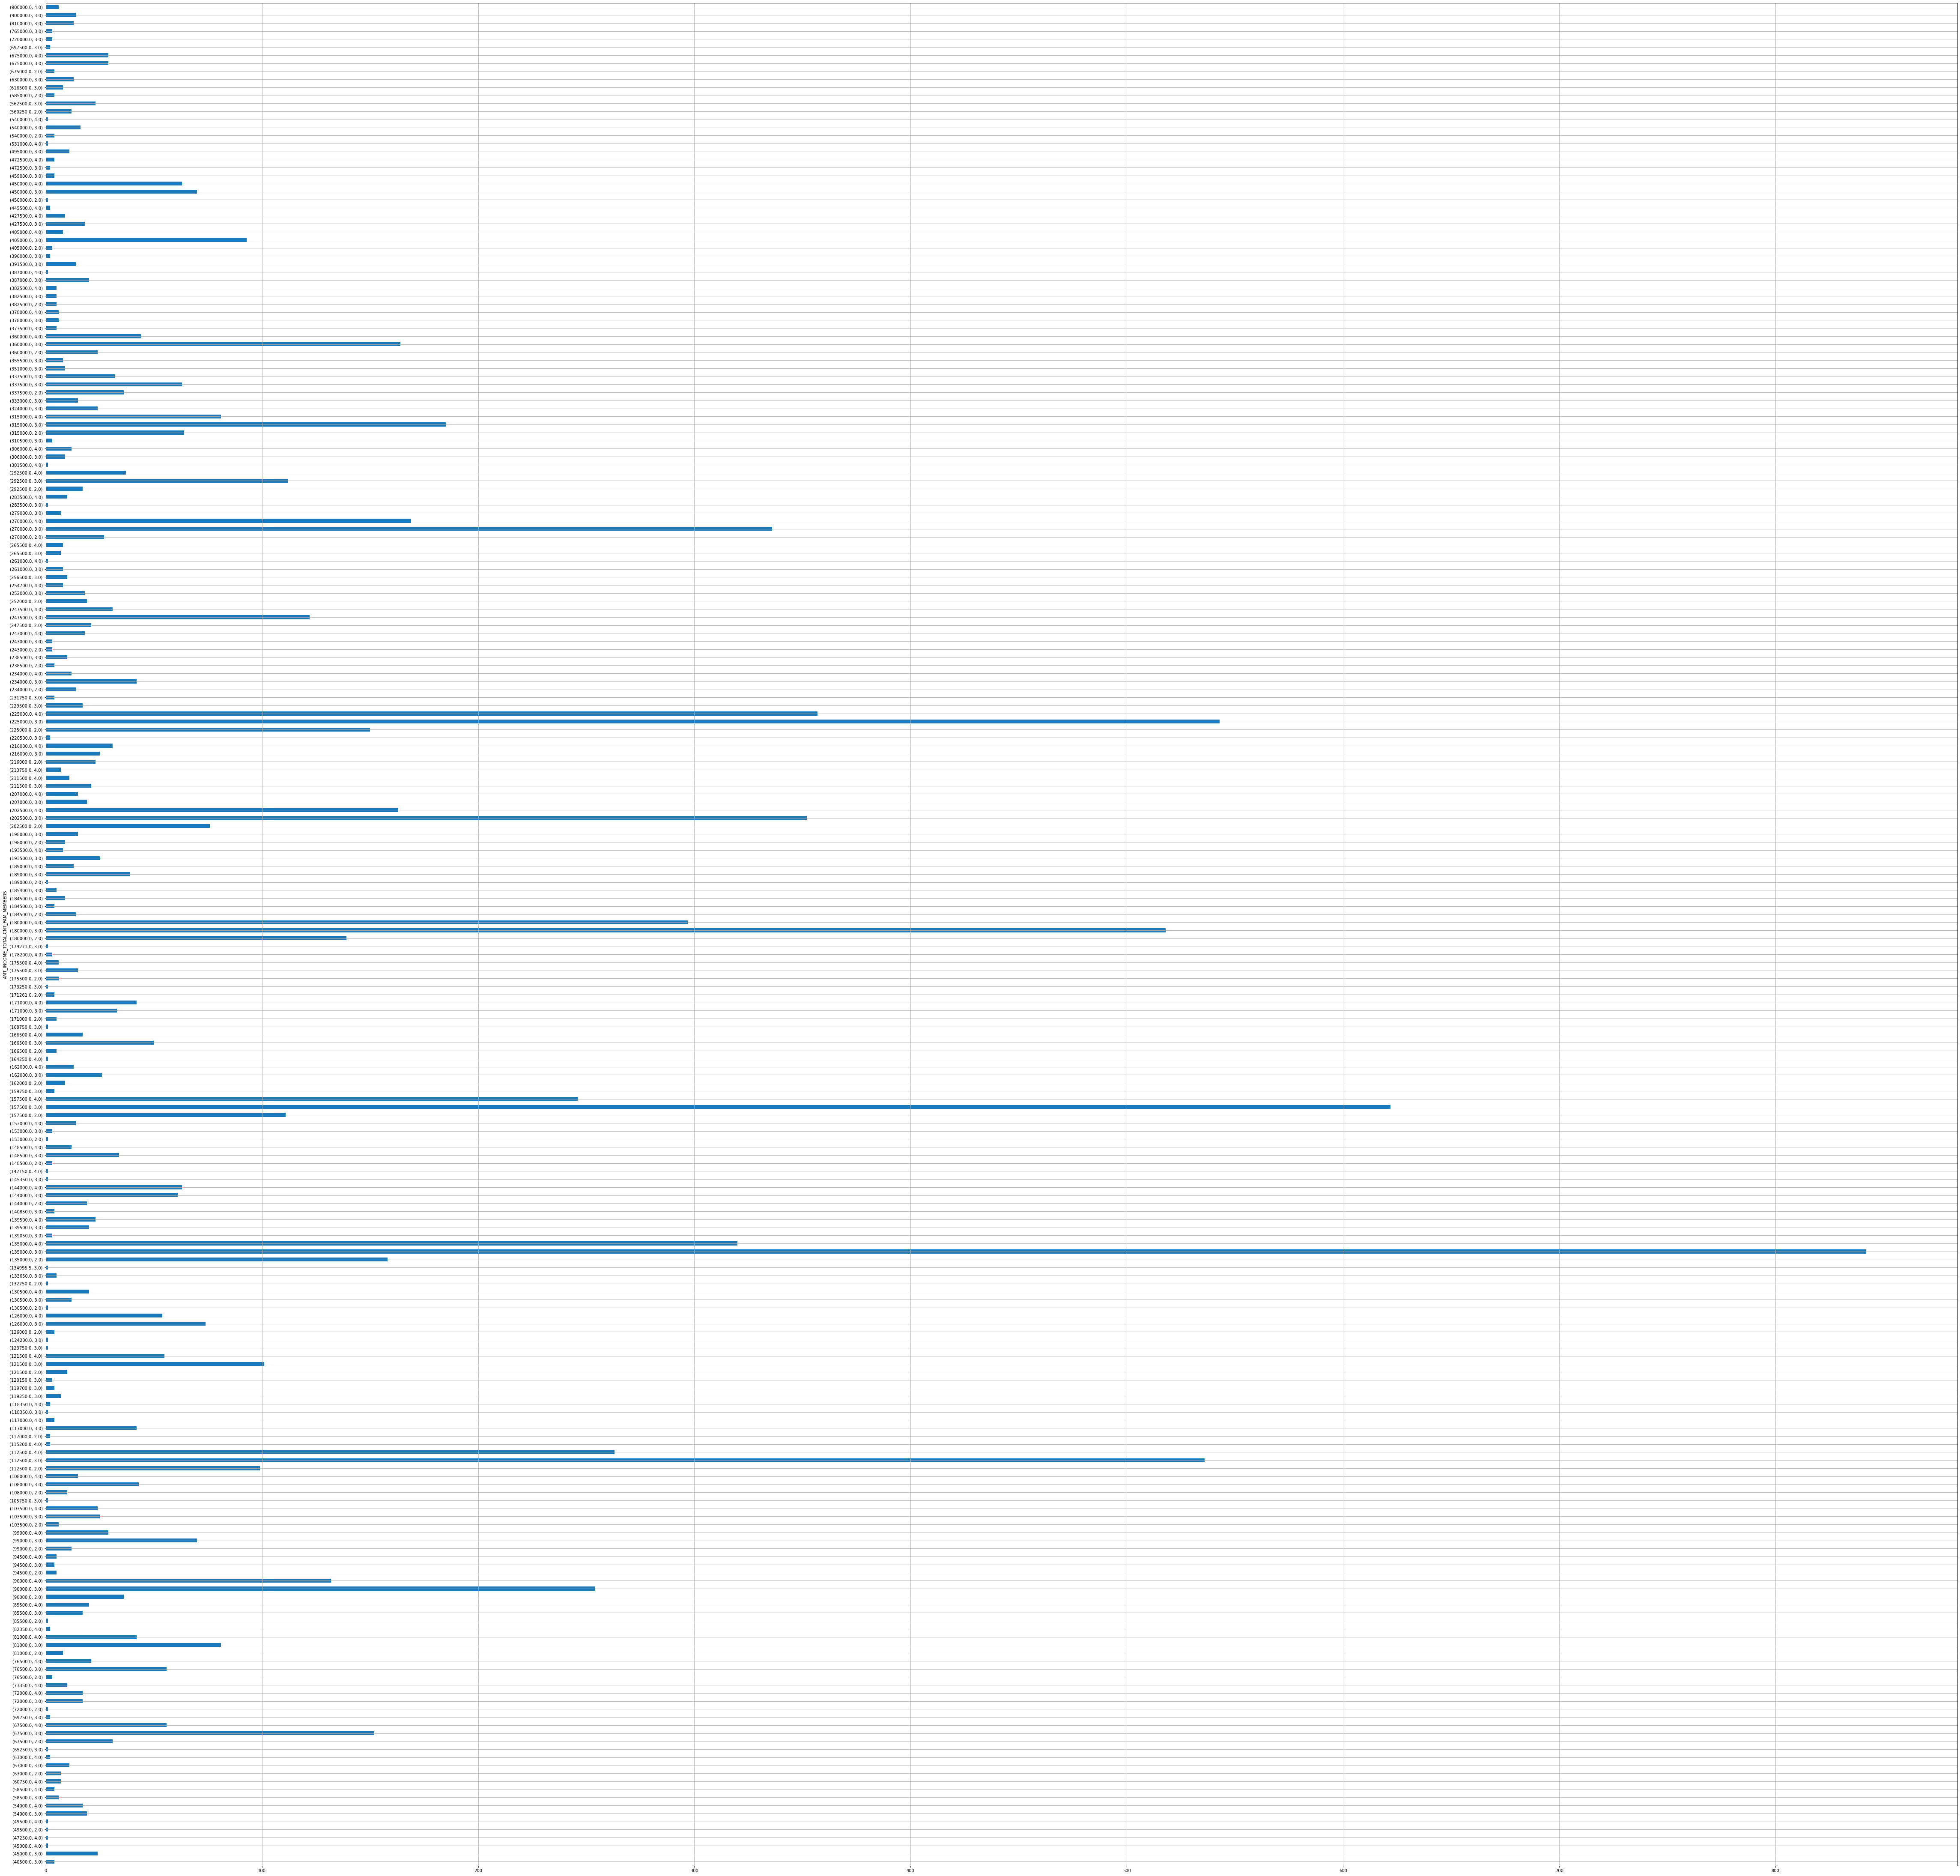

In [34]:
%time
print("Las familias que tienen tres hijos son las que mayor ingreso perciben")
df_union.groupby(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']).size().plot(kind='barh', figsize=(80, 80), grid=True)

Separación de data para entrenamiento y testeo

In [35]:
X = union.iloc[:,1:-1] # X contiene todas las variables excepto el status
y = union.iloc[:,-1] # Y contiene la varibale codificada

In [36]:
## 70 % será para entrenamiento y 30% para testeo
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [37]:
## Normalización de datos
norm = MinMaxScaler()
X_norm = pd.DataFrame(norm.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(norm.transform(X_test), columns=X_test.columns)

In [38]:
## Debido a que los datos no esán balanceados (hay más datos '0' que '1') es necesario
## aplicar técnicas de augmentation para que los modelos puedan predecir la clase que sea minoría
balanceador = SMOTE()
X_balanceado, y_balanceado = balanceador.fit_resample(X_norm, y_train)
X_test_balanceado, y_test_balanceado = balanceador.fit_resample(X_test_norm, y_test)

In [39]:
## Verificación data no balanceada
y_train.value_counts()

0    7383
1     124
Name: STATUS, dtype: int64

In [40]:
## Verificación data no balanceada
y_balanceado.value_counts()

0    7383
1    7383
Name: STATUS, dtype: int64

Aprendizaje de modelos

In [41]:
## Regresión logística
%time
rl = LogisticRegression()
rl.fit(X_balanceado, y_balanceado)
train_score_rl = rl.score(X_balanceado, y_balanceado)
test_score_rl = rl.score(X_test_balanceado, y_test_balanceado)

print("Accuracy de Regresión Logística en set de entrenamiento:", train_score_rl)
print("Accuracy de Regresión Logística en set de prueba:", test_score_rl)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
Accuracy de Regresión Logística en set de entrenamiento: 0.6320601381552214
Accuracy de Regresión Logística en set de prueba: 0.5851164254247955


In [42]:
## KNN
%time
knn = KNeighborsClassifier()
knn.fit(X_balanceado, y_balanceado)
train_score_knn = knn.score(X_balanceado, y_balanceado)
test_score_knn = knn.score(X_test_balanceado, y_test_balanceado)

print("Accuracy de KNN en set de entrenamiento:", train_score_knn)
print("Accuracy de KNN en set de prueba:", test_score_knn)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 9.06 µs
Accuracy de KNN en set de entrenamiento: 0.9730461871867805
Accuracy de KNN en set de prueba: 0.7575519194461926


In [43]:
## Support Vector Machine
%time
svm = SVC()
svm.fit(X_balanceado, y_balanceado)
train_score_svm = svm.score(X_balanceado, y_balanceado)
test_score_svm = svm.score(X_test_balanceado, y_test_balanceado)

print("Accuracy de svm en set de entrenamiento:", train_score_svm)
print("Accuracy de svm en set de prueba:", test_score_svm)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Accuracy de svm en set de entrenamiento: 0.8577813896789923
Accuracy de svm en set de prueba: 0.8082127123977344


In [44]:
## RandomForest
%time
rf = RandomForestClassifier()
rf.fit(X_balanceado, y_balanceado)
train_score_rf = rf.score(X_balanceado, y_balanceado)
test_score_rf = rf.score(X_test_balanceado, y_test_balanceado)

print("Accuracy de svm en set de entrenamiento:", train_score_rf)
print("Accuracy de svm en set de prueba:", test_score_rf)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Accuracy de svm en set de entrenamiento: 0.9943789787349316
Accuracy de svm en set de prueba: 0.855412208936438


In [45]:
## XGBoost
%time
xgBoost = XGBClassifier()
xgBoost.fit(X_balanceado, y_balanceado)
train_score_xgBoost = xgBoost.score(X_balanceado, y_balanceado)
test_score_xgBoost = xgBoost.score(X_test_balanceado, y_test_balanceado)

print("Accuracy de svm en set de entrenamiento:", train_score_xgBoost)
print("Accuracy de svm en set de prueba:", test_score_xgBoost)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Accuracy de svm en set de entrenamiento: 0.8987538940809969
Accuracy de svm en set de prueba: 0.9002517306482064


In [46]:
## El mejor modelo es XGBoost, logra un 87% de accuracy con datos no vistos
## durante el entrenamiento
%time
predicciones = xgBoost.predict(X_test_balanceado)
print(classification_report(y_test_balanceado, predicciones))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3178
           1       0.92      0.87      0.90      3178

    accuracy                           0.90      6356
   macro avg       0.90      0.90      0.90      6356
weighted avg       0.90      0.90      0.90      6356

